In [ ]:
# this may take a few minutes..
%run prep.py

In [1]:
import datetime
import sys
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import dask.dataframe as dd
from dask import compute
from dask.distributed import Client

import pandas as pd

sys.path.insert(0, str(Path(".").resolve().parent.parent))
from src import DATA_DIR
from src.preparation.weather import download_temperature_data

In [2]:
client = Client()
client

Client Scheduler: tcp://127.0.0.1:54584 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 17.18 GB


In [3]:
ddf = dd.read_parquet(
    DATA_DIR / "lcl.snappy.parquet",
    columns=["lclid", "dt", "c", "acorn"],
    engine="fastparquet"
)

df = (
    ddf[(ddf.dt >= "2013-01-01") & (ddf.dt < "2014-01-01")]
    .compute()
)

df.info()

/Users/henryehly/src/low-carbon-london/.venv/lib/python3.7/site-packages/fsspec/implementations/local.py:33: FutureWarning: The default value of auto_mkdir=True has been deprecated and will be changed to auto_mkdir=False by default in a future release.
  FutureWarning,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 93087837 entries, 3840 to 73085
Data columns (total 4 columns):
 #   Column  Dtype         
---  ------  -----         
 0   lclid   object        
 1   dt      datetime64[ns]
 2   c       float32       
 3   acorn   category      
dtypes: category(1), datetime64[ns](1), float32(1), object(1)
memory usage: 2.5+ GB


In [6]:
client.close()

In [7]:
api_token = ""

darksky = download_temperature_data(
    api_token=api_token,
    start=datetime.datetime(2012, 1, 1, tzinfo=datetime.timezone.utc),
    end=datetime.datetime(2014, 3, 1, tzinfo=datetime.timezone.utc),
    progress=True
)

100%|██████████| 790/790 [00:08<00:00, 94.84it/s]


In [10]:
df = (
    df.drop_duplicates(["lclid", "dt"])
    .merge(darksky.temperature, left_on="dt", right_on=darksky.index)
    .set_index("dt")
)

In [29]:
c_mean = df.groupby([df.index.time, df.temperature.round().astype(int)]).c.mean().reset_index()
c_mean.columns = ["time", "temperature", "c"]

In [40]:
c_mean

,time,temperature,c
0,00:00:00,-1,0.276328
1,00:00:00,0,0.260000
2,00:00:00,1,0.264655
3,00:00:00,2,0.256815
4,00:00:00,3,0.248511
...,...,...,...
1369,23:30:00,28,0.153136
1370,23:30:00,29,0.149492
1371,23:30:00,30,0.154246
1372,23:30:00,31,0.154206


In [175]:
c_mean.astype({"time": str}).to_parquet(DATA_DIR / "c_mean.snappy.parquet", compression="snappy")

In [2]:
c_mean = pd.read_parquet(DATA_DIR / "c_mean.snappy.parquet")

In [14]:
import numpy as np
np.array(keys)[0::6]

array(['00:00:00', '03:00:00', '06:00:00', '09:00:00', '12:00:00',
       '15:00:00', '18:00:00', '21:00:00'], dtype='<U8')

<IPython.core.display.Javascript object>


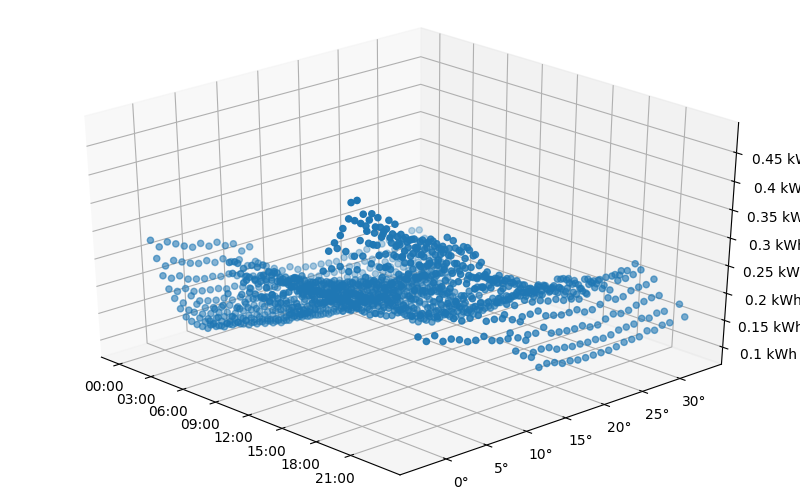

In [43]:
%matplotlib notebook

keys = sorted(c_mean.time.unique())
values = list(range(48))
time_to_slot = dict(zip(keys, values))

fig = plt.figure(figsize=(8, 5))
ax = Axes3D(fig)

xs = c_mean.time.map(time_to_slot)
ys = c_mean.temperature
zs = c_mean.c

ax.scatter(xs, ys, zs, marker="o")

xticks = np.array(values)[0::6]
xticklabels = [i[:5] for i in np.array(keys)[0::6]]

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels)

ax.set_yticklabels([f"{int(t)}°" for t in ax.get_yticks()])

ax.set_zticklabels([f"{round(t, 2)} kWh" for t in ax.get_zticks()])
ax.tick_params(axis="z", pad=10)

plt.show()